# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: ** This is a classification problem because the goal is to define whether the student need early intervention or not, which is basically a classification into two categories, true or false. The problem could be considered as regression if the output would be something such as a likelyhood of needing early intervention, which would be a numerical output.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
n_students = student_data.shape[0]

#Should not consider target column
n_features = student_data.columns[:-1].shape[0]

n_passed = student_data['passed'].value_counts()[0]

n_failed = student_data['passed'].value_counts()[1]

grad_rate = float(n_passed * 100) / (n_passed + n_failed)

print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [3]:
feature_cols = list(student_data.columns[:-1])

target_col = student_data.columns[-1] 

print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Bonus: Exploring the Dataset


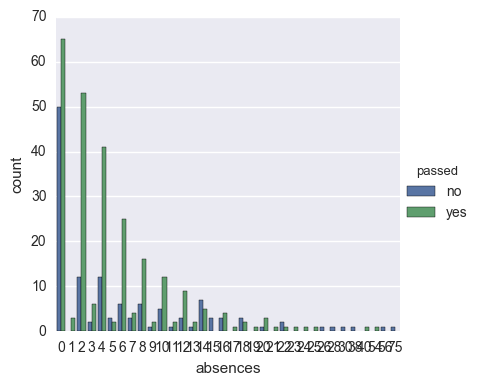

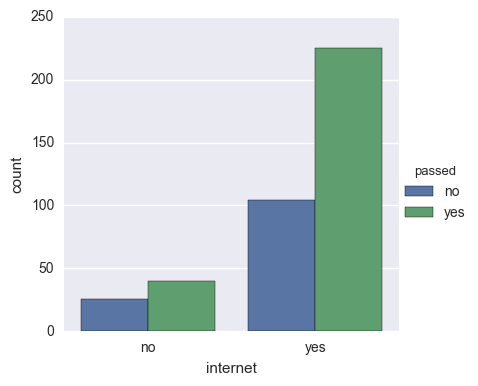

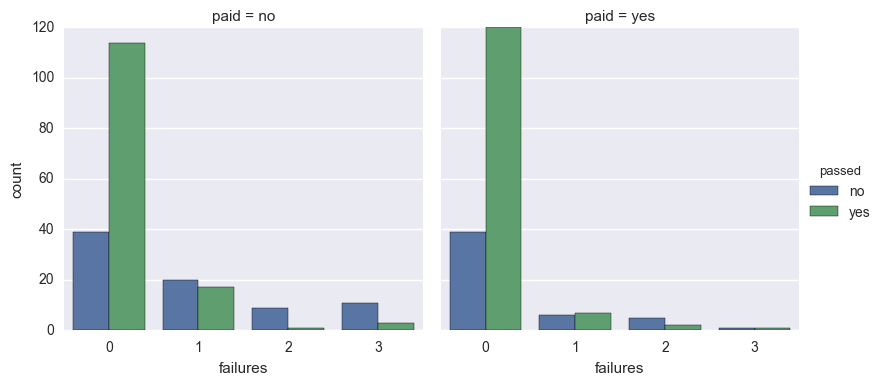

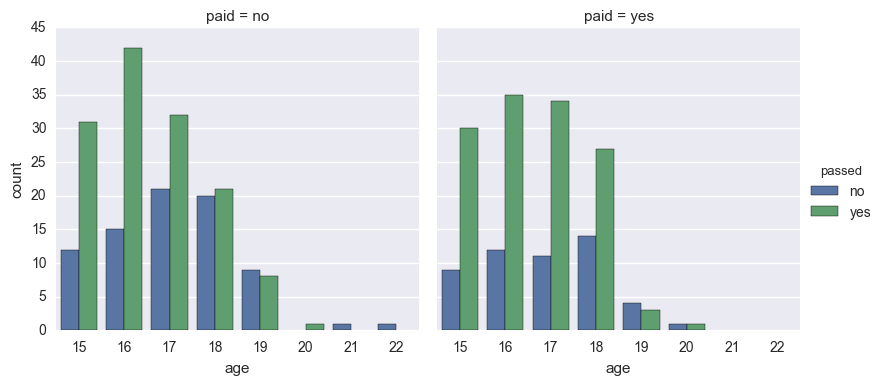

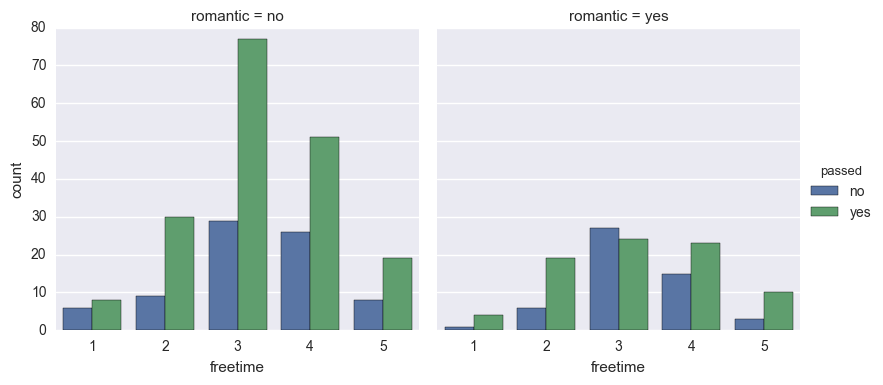

In [4]:
%matplotlib inline
import seaborn as sns
sns.factorplot("absences",  data=student_data, hue='passed', kind="count");
sns.factorplot("internet",  data=student_data, hue='passed', kind="count");
sns.factorplot("failures", col="paid", data=student_data, hue='passed', kind="count");
sns.factorplot("age", col="paid", data=student_data, hue='passed', kind="count");
sns.factorplot("freetime", col="romantic", data=student_data, hue='passed', kind="count");

Using the graphs above, some relation between the considered features and the label can be initially guessed, such as:
    - More absences do not necessarily mean smaller approval rating;
    - Most students have internet access and it gives the impression of helping students to pass as the proportion between passing and reproving students is much higher when they have internet access. Conversely, this could only be a result of the lower population of students who does not have internet, not necessarily being statistically significant;
    - Non-passing students have more failures than the others;
    - Older non-paying students are more prone to not passing;
    - Freetime does not seem to have much relation to passing. Alternatively, students with 3 hours of freetime and romantic seem to be more likely to fail.

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [5]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [6]:
from sklearn import cross_validation
num_train = 300
num_test = X_all.shape[0] - num_train
test_split = num_test % (num_train + num_test)

randomState = 9

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, test_size=test_split, 
                                                                     random_state=randomState, stratify=y_all)


print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])
#Checking stratification
print "Grad rates:\nTrain set = {:.2f}%".format(100 * (y_train == 'yes').mean())
print "Test set = {:.2f}%".format(100 * (y_test == 'yes').mean())

Training set has 300 samples.
Testing set has 95 samples.
Grad rates:
Train set = 67.00%
Test set = 67.37%


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **
For this problem, there are several learning models, which are appropriate:
     - Naive Bayes: 
        - One real-world application of this model is classifying spam email as it does not requires as much data as other to estimate the parameters necessary for classification and is quite fast. 
        - The advantages of this model are: simple implementation, fast and has good results even with small datasets.
        - The disadvantages of this model are: poor results on cases where there is strong probabilistic dependence between features and where the values associated with the classes are not distributed according to a gaussian distribution.In addition, this model is likely to overfit the data without regularization or similar strategies.
        - This model makes a good candidate for the problem as the dataset is not so vast and the values associated with the classes are likely to be follow a gaussian distribution.
        
        
    - Support Vector Machine: this model is used for both regression and classification and can be applied, 
        -One real-world application in industry is on recognizing hand-written characters as this model is capable of producing non-linear decision boundries, which may provide excellent results.
        - The strengths of the model are that training SVMs is less computationally expensive than neural networks, which are able to produce similar decision boundaries and are also suitable for problems such as MINST. Also, SVMs have the advantage of performing well even on datasets where the ratio between features and samples is not high. 
        - The disadvantages of the model are: being computationally expensive on both training and testing phases and being restricted to decision boundries either linear or generated by kernels. Also, this model is restricted to binary classification, demanding extra work for multi-class use.
        - This model is suitable for the problem as it provides many decision boundary shapes, making it likely to result on a good fit for the dataset. 
        
        
        
    - Decision Trees: this model is most applied to cases when the parameters of the final model must be easily understandable by humans. 
        - One interesting real world application is stock trade, as the prices of different stocks are correlated and closely liked to market and economic indicators. In this application, this model produces many decision boundaries clearly understandable by humans, which makes it more presentable to clients such as investors counting on the model to have good return rates. ( https://inovancetech.com/blogML3.html, http://eugenezhulenev.com/blog/2014/11/14/stock-price-prediction-with-big-data-and-machine-learning/)
        - This model performs well even with large datasets and is extremely valuable when human interpretation of the model is necessary. In addition, it has the advantage of simultaneously handling numerical and categorical values 
        - Decision trees have limitations such as difficulty to model some specific boundries(such as XOR problem), generating trees larger than expected. Also, extra caution is needed to avoid overfitting, as this model can easily generate over-complex solution which generalize poorly. 
        - The model makes a good candidate for the problem as it's a classification problem which handles both cathegorical and numerical values. Also, for this case, having a solution which is clear for humans to understand would be valuable, as it makes the impact of decisions clearer. 


### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [7]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree

clf_A = GaussianNB()
clf_B = svm.SVC(random_state=randomState)
clf_C = tree.DecisionTreeClassifier(random_state=randomState)

models = [clf_A, clf_B, clf_C]

for classifier in models:
    print  "\n{}: \n".format(classifier.__class__.__name__)
    for n in [100, 200, 300]:
        train_predict(classifier, X_train[:n], y_train[:n], X_test, y_test)


GaussianNB: 

Training a GaussianNB using a training set size of 100. . .
Trained model in 0.0000 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 0.7863.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.5893.
Training a GaussianNB using a training set size of 200. . .
Trained model in 0.0000 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 0.8031.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.6452.
Training a GaussianNB using a training set size of 300. . .
Trained model in 0.0040 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 0.8098.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.7087.

SVC: 

Training a SVC using a training set size of 100. . .
Trained model in 0.0040 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 0.8310.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.8054.
Training a SVC using a training set size of 200. . .
Trained mod

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - Gaussian NB**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100|0.0040|0.0000|0.7863|0.5893              |
| 200|0.0040|0.0080|0.8031|0.6452           |
| 300|0.0080|0.0020|0.8098|0.7087      |

** Classifer 2 - SVM **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100|0.0000|0.0040|0.8310|0.8054              |
| 200|0.0040|0.0000|0.8873|0.7482          |
| 300|0.0060|0.0020|0.8709|0.7891     |

** Classifer 3 - Decision Tree**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100|0.0010|0.0000|1|0.6777|
| 200|0.0010|0.0000|1|0.7761|
| 300|0.0000|0.0000|1|0.7244|

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: ** Based on the experiments, the SVM model was chosen as the best considering the data available as it is the one with highest scores when prediction the test data. This is model is quite suitable for many applications as it is versatile and allows different tunings to represent a phenomena more accurately. Although this model is not as fast as the others, it is still fast enough to use without any sort of issues.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** Classification models are used when there is a necessity of separating data into predetermined classes. Supposing the need of separating the students into two categories, the ones who need early intervention and the ones who don't, considering for instance, free time and absences. In this case, we would probably be able to draw a line based on the two features which separates the students who need help and the ones who don't. What the SVM model do is find this line and actually choose the line which generates the greatest distance between the attributes for students from both classes. This model is so powerful that it is able to separate the classes even if a single line can´t be used, as there is the kernel trick, which basically tranform shapes which are not separable by a line into others that are. For real problems such as the one in case, the number of features is much higher than two, which creates the necessity for the separation boundary to transfor from a single line to actually high dimensional planes, called hyperplanes.
The training of these models is done by finding the line or plane that best separates the two possible groups, which generates some points that are used as guides to the separation borders. Finally, the model is called Support Vector MAchine because this training procedure generates a set of datapoints which are the basis of the optimal separation hyperplane.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [11]:
from sklearn import grid_search
from sklearn.metrics import  make_scorer
parameters = {'kernel': ['rbf'],
              'C':[0.1, 1, 5, 10, 100],
              'gamma':[0.1, 0.01, 0.02, 'auto', 0.03, 0.001, 0.0001],
              'degree':[1, 2, 3, 4, 5, 6]}


clf = svm.SVC(random_state=randomState)

f1_scorer = make_scorer(f1_score, pos_label="yes")

grid_obj = grid_search.GridSearchCV(clf, parameters, f1_scorer)

grid_obj = grid_obj.fit(X_train, y_train)


# Get the estimator
clf = grid_obj.best_estimator_
print clf

print "F1 score for predicting all \"yes\" on test set: {:.4f}".format(
    f1_score(y_test, ['yes']*len(y_test), pos_label='yes', average='binary'))

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

#from IPython.display import display
#display(pd.DataFrame(grid_obj.grid_scores_))


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=1, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=9, shrinking=True,
  tol=0.001, verbose=False)
F1 score for predicting all "yes" on test set: 0.8050
Made predictions in 0.0160 seconds.
Tuned model has a training F1 score of 0.9781.
Made predictions in 0.0000 seconds.
Tuned model has a testing F1 score of 0.8052.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: ** The F1 score for the tuned model is 0.9781 for training and 0.8052 for testing. This model is only around 2% more accurate than the untuned one and almost as precise as considering all results as yes, which indicates that more work, such as normalizing the features, would be necessary for a better result. On both prior submissions, teh result of teh untuned model was quite close to the tuned one, with the difference that on the first one C and gamma changed a lot from the untuned model, proving that a different combination of these parameters may result on similar results. Conversely, in the second submission both optimal parameters are quite close to the untuned ones, as C is the same, 1, and gamma is quite similar, 0.02 while the untuned is 1/n_features=0.0208. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.